# 06.12.2024

In [13]:
import scipy.stats as sps
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt 
import numpy as np
import math

from functools import lru_cache

In [2]:
@lru_cache
def get_distributions(E: float = 0, D: float = 1) -> dict[str, sps.rv_continuous]:
    unif_scale = 2 * math.sqrt(3 * D)
    unif_loc = E - unif_scale / 2
    return {
        'Norm': sps.norm(loc=E, scale=math.sqrt(D)),
        'Uniform': sps.uniform(loc=unif_loc, scale=unif_scale),
        'Exp': sps.expon(loc=E - math.sqrt(D), scale=math.sqrt(D))
    }

In [3]:
N = 2 * 10 ** 2
n = 100
DELTA = 0.2
ALPHA = 0.05

Сгенерируем основной сигнал вида $$x(t) = 5 e^{-\frac{2t}{n}}, \;\; t \in \{0, 1, 2, \dotsc, n-1\}$$

In [4]:
base_signal = 5 * np.exp((-2 * np.arange(n)) / n)

Сгенерируем сигналы, которые являются основным сигналом + шум из соответствующих распределений.

In [5]:
signals = {d_name: [base_signal + d.rvs(n) for _ in range(N)] for d_name, d in get_distributions().items()}

Посчитаем для них автокорреляционную функцию

In [23]:
# plot_acf(x=signals["Norm"][1], lags=n-1, alpha=0.05, zero=False)

In [6]:
acfs = {d_name: [acf(signal, nlags=n-1)[1:] for signal in generated_signals] for d_name, generated_signals in signals.items()}

И доверительные интервалы для их значений

In [7]:
acfs_conf_int = {d_name: np.array(DescrStatsW(acf_values).tconfint_mean(ALPHA)) for d_name, acf_values in acfs.items()}

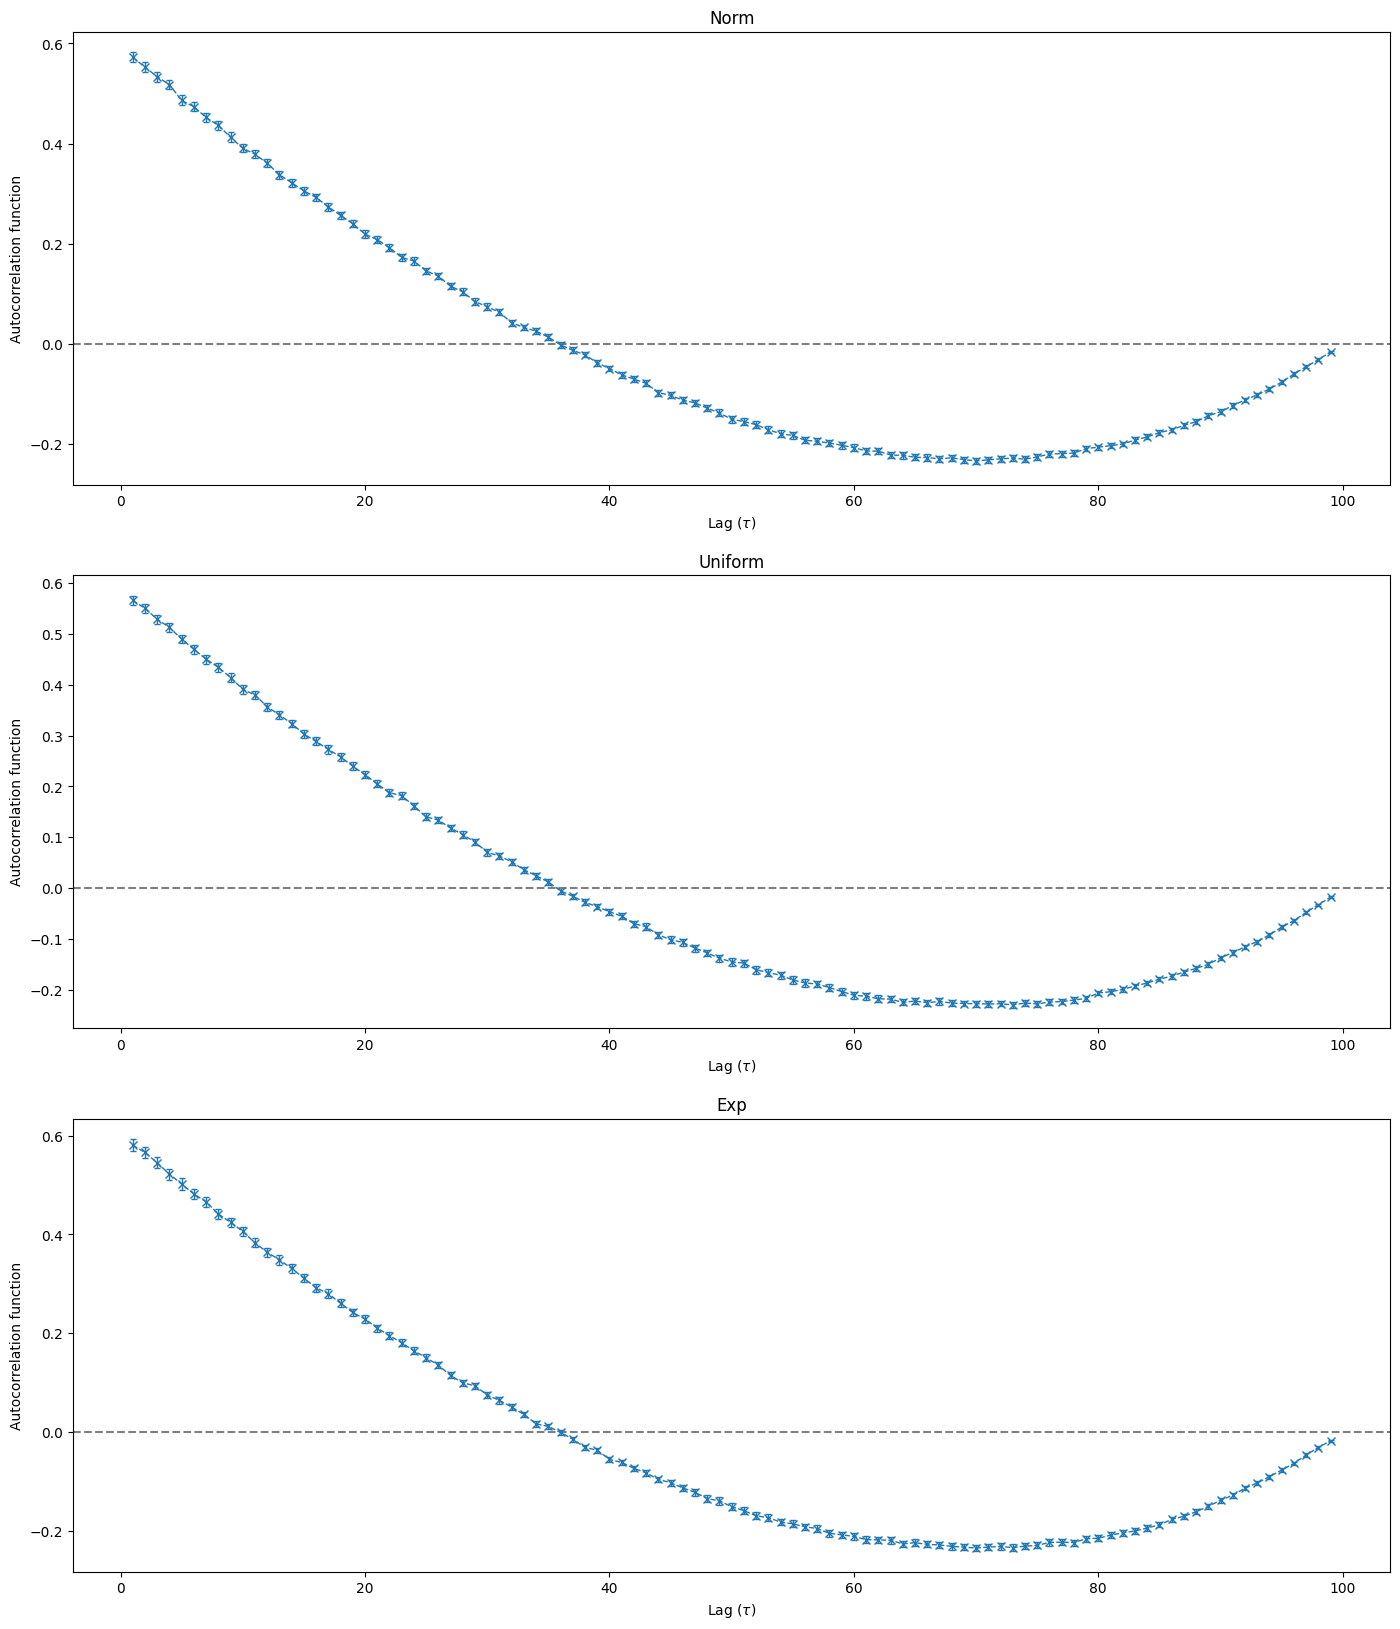

In [8]:
_, axes = plt.subplots(3, 1, figsize=(17, 20))
for i, (d_name, acf_values) in enumerate(acfs.items()):
    ax: plt.Axes = axes[i]
    mean_acf_values = np.mean(acf_values, axis=0)
    ax.errorbar(list(range(1, n)), mean_acf_values, yerr=np.abs(acfs_conf_int[d_name] - mean_acf_values), fmt='x--', linewidth=1, capsize=2)
    ax.axhline(0, linestyle='--', color='gray')
    ax.title.set_text(d_name)
    ax.set_ylabel('Autocorrelation function')
    ax.set_xlabel('Lag ($\\tau$)')

Как и ожидалось, чем больше сдвиг $\tau$, тем ближе к нулю автокорреляционная функция

Теперь оценим функцию распределения минимальных значений $\tau_0 = \min\{\tau \mid 0 \in I_{A(\tau)}\}$

In [9]:
acfs_all_conf_ints = {d_name: [acf(signal, nlags=n-1, alpha=ALPHA)[1] for signal in generated_signals] for d_name, generated_signals in signals.items()}

In [10]:
tau_values = {d_name: [min([ind + 1 for ind, (low, high) in enumerate(d_acfs_cond_int) if low <= 0 <= high]) for d_acfs_cond_int in d_acfs_all_conf_ints] for d_name, d_acfs_all_conf_ints in acfs_all_conf_ints.items()}

Эмпирические функции распределения

In [11]:
ecdfs = {d_name: sps.ecdf(taus).cdf for d_name, taus in tau_values.items()}

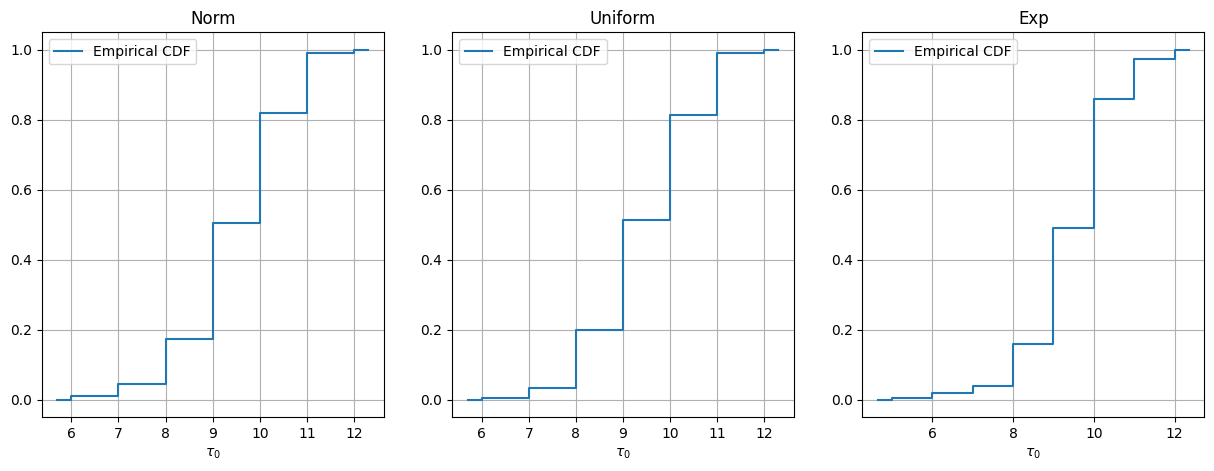

In [12]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (d_name, ecdf) in enumerate(ecdfs.items()):
    ax: plt.Axes = axes[i]
    ecdf.plot(ax, **{'label': 'Empirical CDF'})
    ax.title.set_text(d_name)
    ax.set_xlabel('$\\tau_0$')
    ax.grid()
    ax.legend()

Как видно, значения очень быстро становятся единицей. Это и не удивительно, поскольку автокорреляционная функция является мерой случайности сигнала, а значит в нашем случае (полностью случайный сигнал), она должна зануляться почти сразу, а следовательно $\tau_0$ будут очень маленькими, что мы и наблюдаем.

In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 3000
n = 100
alpha = 0.2
lower_p = 100*alpha/2
upper_p = 100*(1 - alpha/2)

t = np.arange(n)*1.0 + 0.1

def normalize(sig):
    return (sig - np.mean(sig))/np.std(sig)

def generate_signals(dist_name, N, n, t):
    signals = []
    for _ in range(N):
        A = np.random.uniform(4,6)
        delta = np.random.uniform(-0.5,0.5)
        x_det = A * np.exp(-2*(1+delta)*t/n)

        if dist_name == 'normal':
            noise = np.random.randn(n)*np.random.uniform(0.5,1.5)
        elif dist_name == 'uniform':
            noise = (np.random.rand(n)-0.5)*np.sqrt(12)*np.random.uniform(0.5,1.5)
        elif dist_name == 'exp':
            noise = (np.random.exponential(1,n)-1)*np.random.uniform(0.5,1.5)
        else:
            raise ValueError("Unknown distribution")
        s = x_det + noise
        s = normalize(s)
        signals.append(s)
    return signals

signals_normal = generate_signals('normal', N, n, t)
signals_uniform = generate_signals('uniform', N, n, t)
signals_exp = generate_signals('exp', N, n, t)

def compute_acfs(signals, n):
    R = []
    for s in signals:
        R.append(acf(s, nlags=n-1, fft=True))
    return np.array(R)

R_normal = compute_acfs(signals_normal, n)
R_uniform = compute_acfs(signals_uniform, n)
R_exp = compute_acfs(signals_exp, n)

def percentile_ci(R):
    lower_bound = np.percentile(R, lower_p, axis=0)
    upper_bound = np.percentile(R, upper_p, axis=0)
    mean_val = np.mean(R, axis=0)
    return mean_val, lower_bound, upper_bound

means_normal, low_normal, high_normal = percentile_ci(R_normal, alpha=alpha)
means_uniform, low_uniform, high_uniform = percentile_ci(R_uniform, alpha=alpha)
means_exp, low_exp, high_exp = percentile_ci(R_exp, alpha=alpha)

def first_tau_includes_zero(R, low_ci, high_ci):
    tau_values = []
    for i in range(R.shape[0]):
        found_tau = None
        for tau in range(1, R.shape[1]):
            if low_ci[tau]<=0<=high_ci[tau]:
                found_tau = tau
                break
        if found_tau is None:
            found_tau = R.shape[1]
        tau_values.append(found_tau)
    return tau_values

tau_normal = first_tau_includes_zero(R_normal, low_normal, high_normal)
tau_uniform = first_tau_includes_zero(R_uniform, low_uniform, high_uniform)
tau_exp = first_tau_includes_zero(R_exp, low_exp, high_exp)

plt.figure()
plt.hist(tau_normal, bins=range(0,n+1), edgecolor='black', alpha=0.7)
plt.title('Distribution of tau (Normal + deterministic modified)')
plt.xlabel('tau')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(tau_uniform, bins=range(0,n+1), edgecolor='black', alpha=0.7)
plt.title('Distribution of tau (Uniform + deterministic modified)')
plt.xlabel('tau')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(tau_exp, bins=range(0,n+1), edgecolor='black', alpha=0.7)
plt.title('Distribution of tau (Exp + deterministic modified)')
plt.xlabel('tau')
plt.ylabel('Count')
plt.show()

print("Mean tau (normal):", np.mean(tau_normal))
print("Mean tau (uniform):", np.mean(tau_uniform))
print("Mean tau (exp):", np.mean(tau_exp))

lags = np.arange(n)
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.plot(lags, means_normal, label='Mean ACF (Normal)')
plt.fill_between(lags, low_normal, high_normal, color='gray', alpha=0.3, label='95% CI')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normal noise + variable deterministic')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()

plt.subplot(1,3,2)
plt.plot(lags, means_uniform, label='Mean ACF (Uniform)')
plt.fill_between(lags, low_uniform, high_uniform, color='gray', alpha=0.3, label='95% CI')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Uniform noise + variable deterministic')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()

plt.subplot(1,3,3)
plt.plot(lags, means_exp, label='Mean ACF (Exponential)')
plt.fill_between(lags, low_exp, high_exp, color='gray', alpha=0.3, label='95% CI')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Exponential noise + variable deterministic')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.legend()

plt.tight_layout()
plt.show()

TypeError: percentile_ci() got an unexpected keyword argument 'alpha'